In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("loan-train.csv")
test = pd.read_csv("loan-test.csv")

In [3]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


### EDA

In [5]:
train.shape

(614, 13)

In [6]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


### Treating Null Values

In [7]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [8]:
train.dropna(inplace=True)

In [9]:
train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [10]:
test.dropna(inplace=True)

### Categorical Encoding

In [11]:
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [12]:
train.Education.unique()

array(['Graduate', 'Not Graduate'], dtype=object)

In [13]:
train.Self_Employed.unique()

array(['No', 'Yes'], dtype=object)

In [14]:
train.Property_Area.unique()

array(['Rural', 'Urban', 'Semiurban'], dtype=object)

In [15]:

le = LabelEncoder()
train['Gender'] = le.fit_transform(train['Gender'])
train['Married'] = le.fit_transform(train['Married'])
train['Education'] = le.fit_transform(train['Education'])
train['Self_Employed'] = le.fit_transform(train['Self_Employed'])
train['Property_Area'] = le.fit_transform(train['Property_Area'])


In [16]:
train.Dependents.unique()

array(['1', '0', '2', '3+'], dtype=object)

In [17]:
dependents_encoder = {'0':0, '1':1, '2':2, '3+':3}
train['Depedents_en'] = train.Dependents.map(dependents_encoder)
train.drop("Dependents", axis=1, inplace=True)

In [18]:
train.head()

,Loan_ID,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Depedents_en
1,LP001003,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,N,1
2,LP001005,1,1,0,1,3000,0.0,66.0,360.0,1.0,2,Y,0
3,LP001006,1,1,1,0,2583,2358.0,120.0,360.0,1.0,2,Y,0
4,LP001008,1,0,0,0,6000,0.0,141.0,360.0,1.0,2,Y,0
5,LP001011,1,1,0,1,5417,4196.0,267.0,360.0,1.0,2,Y,2


In [19]:
train.dtypes

Loan_ID               object
Gender                 int32
Married                int32
Education              int32
Self_Employed          int32
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int32
Loan_Status           object
Depedents_en           int64
dtype: object

In [20]:
train.drop('Loan_ID', axis=1, inplace=True)
test.drop('Loan_ID', axis=1, inplace =True)

In [21]:
## encoding on test dataset
test['Gender'] = le.fit_transform(test['Gender'])
test['Married'] = le.fit_transform(test['Married'])
test['Education'] = le.fit_transform(test['Education'])
test['Self_Employed'] = le.fit_transform(test['Self_Employed'])
test['Property_Area'] = le.fit_transform(test['Property_Area'])
test['Depedents_en'] = test.Dependents.map(dependents_encoder)
test.drop("Dependents", axis=1, inplace=True)

In [22]:
test.columns

Index(['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Property_Area', 'Depedents_en'],
      dtype='object')

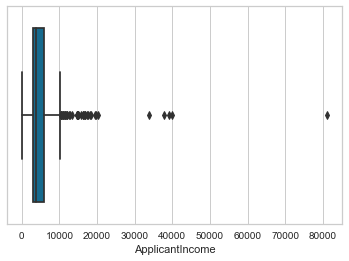

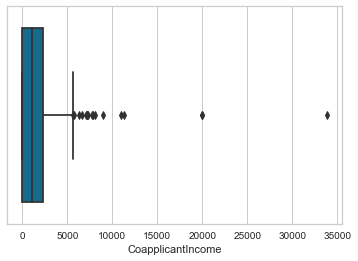

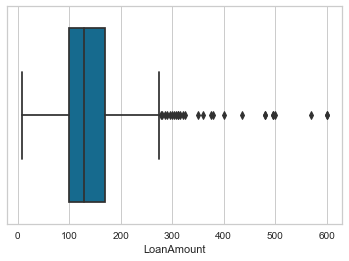

In [23]:
## checking ouliers of continuous variables

t = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

for col in t:
    sn.boxplot(train[col])
    
    plt.show()

In [24]:
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1
df = train[t]
df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [25]:
df[['Gender','Married','Education','Self_Employed','Property_Area','Loan_Status','Depedents_en', 'Credit_History', 'Loan_Amount_Term']] = train[['Gender','Married','Education','Self_Employed','Property_Area','Loan_Status','Depedents_en', 'Credit_History', 'Loan_Amount_Term']]
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender,Married,Education,Self_Employed,Property_Area,Loan_Status,Depedents_en,Credit_History,Loan_Amount_Term
1,4583,1508.0,128.0,1,1,0,0,0,N,1,1.0,360.0
2,3000,0.0,66.0,1,1,0,1,2,Y,0,1.0,360.0
3,2583,2358.0,120.0,1,1,1,0,2,Y,0,1.0,360.0
4,6000,0.0,141.0,1,0,0,0,2,Y,0,1.0,360.0
5,5417,4196.0,267.0,1,1,0,1,2,Y,2,1.0,360.0


In [26]:
df.Credit_History.unique()

array([1., 0.])

<AxesSubplot:>

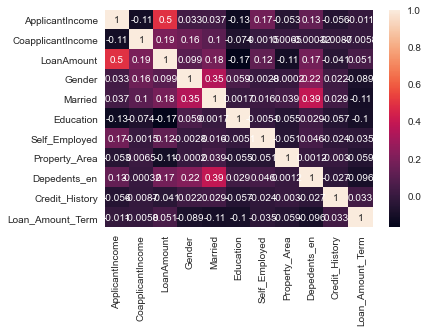

In [27]:
sn.heatmap(df.corr(), annot=True)

### Balancing Dataset

In [28]:
## balancing dataset
y,n = df.Loan_Status.value_counts()
(y*100)/(y+n), (n*100)/(y+n)

(69.16666666666667, 30.833333333333332)

In [29]:
x = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']
Counter(y)

Counter({'N': 148, 'Y': 332})

In [30]:
## The combination of SMOTE and under-sampling performs better than plain under-sampling.
# Oversample with SMOTE and random undersample for imbalanced dataset

# define pipeline
over = SMOTE(sampling_strategy=0.6)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X, Y = pipeline.fit_resample(x, y)
# summarize the new class distribution
counter = Counter(Y)
print(counter)

Counter({'Y': 248, 'N': 199})


In [31]:
X.shape

(447, 11)

In [32]:
train_n = X.copy()
train_n['Loan_Status'] = Y
train_n.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender,Married,Education,Self_Employed,Property_Area,Depedents_en,Credit_History,Loan_Amount_Term,Loan_Status
0,4583,1508.0,128.0,1,1,0,0,0,1,1.0,360.0,N
1,3036,2504.0,158.0,1,1,0,0,1,3,0.0,360.0,N
2,12841,10968.0,349.0,1,1,0,0,1,1,1.0,360.0,N
3,1853,2840.0,114.0,1,0,0,0,0,0,1.0,360.0,N
4,3510,0.0,76.0,0,0,0,0,2,0,0.0,360.0,N


#### Standardization

In [33]:
train_n['Loan_Status'] = le.fit_transform(train_n['Loan_Status'])

In [34]:
df_scaled = train_n.copy()
scalar = MinMaxScaler()
df_scaled = scalar.fit_transform(train_n)
df_scaled

array([[0.05482993, 0.0445666 , 0.20135364, ..., 1.        , 0.72972973,
        0.        ],
       [0.03569573, 0.07400183, 0.25211506, ..., 0.        , 0.72972973,
        0.        ],
       [0.1569697 , 0.32414221, 0.57529611, ..., 1.        , 0.72972973,
        0.        ],
       ...,
       [0.04761905, 0.07388362, 0.22165821, ..., 1.        , 0.72972973,
        1.        ],
       [0.07544836, 0.16709519, 0.30287648, ..., 1.        , 0.32432432,
        1.        ],
       [0.04730983, 0.07479978, 0.07783418, ..., 1.        , 0.72972973,
        1.        ]])

In [35]:
new_train = pd.DataFrame(df_scaled, columns=train_n.columns)
new_train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender,Married,Education,Self_Employed,Property_Area,Depedents_en,Credit_History,Loan_Amount_Term,Loan_Status
0,0.054830,0.044567,0.201354,1.0,1.0,0.0,0.0,0.0,0.333333,1.0,0.72973,0.0
1,0.035696,0.074002,0.252115,1.0,1.0,0.0,0.0,0.5,1.000000,0.0,0.72973,0.0
2,0.156970,0.324142,0.575296,1.0,1.0,0.0,0.0,0.5,0.333333,1.0,0.72973,0.0
3,0.021064,0.083932,0.177665,1.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.72973,0.0
4,0.041558,0.000000,0.113367,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.72973,0.0


### Feature Selection

<AxesSubplot:>

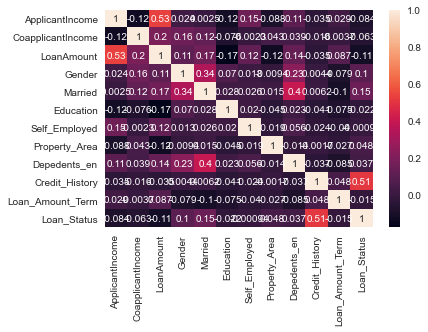

In [36]:
sn.heatmap(train_n.corr(), annot=True)

In [37]:
corr = new_train.corr()

## Use k-means algorithm with k =3 to generate a cluster model with the Loans_Training data set.

In [38]:
train_n['Loan_Status'] = le.fit_transform(train_n.Loan_Status)
train_n['Loan_Status'].unique()

array([0, 1], dtype=int64)

In [39]:
train_n.dtypes

ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Gender                 int32
Married                int32
Education              int32
Self_Employed          int32
Property_Area          int32
Depedents_en           int64
Credit_History       float64
Loan_Amount_Term     float64
Loan_Status            int64
dtype: object

In [40]:
 #import libraries for performing kmeans 

clusterer = KMeans(n_clusters=3, random_state=10)
cluster_labels = clusterer.fit_predict(train_n)
centroids  = clusterer.cluster_centers_

In [41]:
c = Counter(cluster_labels)
c

Counter({0: 387, 2: 59, 1: 1})

In [42]:
cls_df = train_n
cls_df['cluster'] = cluster_labels

In [43]:
cls_df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender,Married,Education,Self_Employed,Property_Area,Depedents_en,Credit_History,Loan_Amount_Term,Loan_Status,cluster
0,4583,1508.0,128.0,1,1,0,0,0,1,1.0,360.0,0,0
1,3036,2504.0,158.0,1,1,0,0,1,3,0.0,360.0,0,0
2,12841,10968.0,349.0,1,1,0,0,1,1,1.0,360.0,0,2
3,1853,2840.0,114.0,1,0,0,0,0,0,1.0,360.0,0,0
4,3510,0.0,76.0,0,0,0,0,2,0,0.0,360.0,0,0


## Generate a silhouette plot of your cluster model

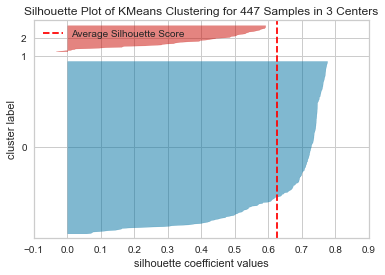

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 447 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [44]:
visualizer = SilhouetteVisualizer(clusterer, colors='yellowbrick')

visualizer.fit(cls_df.drop('Loan_Status', axis=1))        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Calculate the mean silhouette values for each cluster, as well as the overall mean silhouette for the cluster model.

In [45]:
sample_silhouette_values = silhouette_samples(cls_df, cluster_labels)
num_clusters = 3
means_lst = []
for label in range(num_clusters):
    means_lst.append(sample_silhouette_values[cluster_labels == label].mean())

silhouette_avg = silhouette_score(cls_df, cluster_labels)
silhouette_avg

print("Calculate the mean silhouette values for each cluster : ", means_lst)
print()
print("Average Score : ", silhouette_avg)

Calculate the mean silhouette values for each cluster :  [0.6666216533717135, 0.0, 0.3789621498092054]

Average Score :  0.6271618494263899


###  Provide a two-dimensional scatter plot, using variables of your choice, with an overlay of cluster membership. Choose variables that result in an interesting plot. Note where the cluster boundaries are close, and where they are not so close.

No handles with labels found to put in legend.


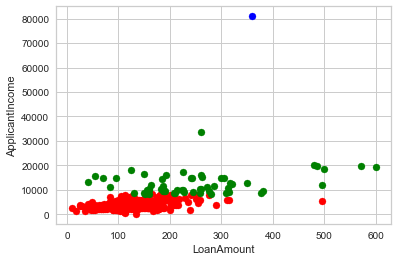

In [46]:
## lets use gender and Self_employed
df0 = cls_df[cls_df['cluster']==0]
df1 = cls_df[cls_df['cluster']==1]
df2 = cls_df[cls_df['cluster']==2]


plt.scatter(df0["LoanAmount"], df0['ApplicantIncome'], color = 'red')#, c = cluster_labels, cmap='plasma')
plt.scatter(df1["LoanAmount"], df1['ApplicantIncome'], color = 'blue')
plt.scatter(df2["LoanAmount"], df2['ApplicantIncome'], color = 'green')


plt.xlabel("LoanAmount")
plt.ylabel("ApplicantIncome")
plt.legend()
plt.show()

### Using the same variables as in the Question number 4, provide a two-dimensional scatter plot, with an overlay of binned silhouette values. Comment on the relationship between your two scatter plots

In [47]:
c = dict(Counter(cluster_labels))
cls_lbl, num = c.keys, c.values


In [48]:
#plt.scatter(cls_lbl, num)

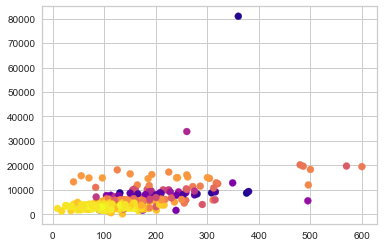

In [49]:
plt.scatter(cls_df["LoanAmount"], cls_df['ApplicantIncome'], c = sample_silhouette_values, cmap='plasma')

In [50]:
clusterer_4 = KMeans(n_clusters=4, random_state=0)
cluster_labels_4 = clusterer_4.fit_predict(train_n)
centroids_4  = clusterer.cluster_centers_

In [51]:
Counter(cluster_labels_4)

Counter({0: 381, 2: 62, 1: 1, 3: 3})

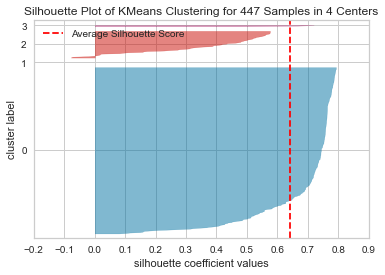

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 447 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [52]:
visualizer = SilhouetteVisualizer(clusterer_4, colors='yellowbrick')

visualizer.fit(train_n) #.drop('Loan_Status',axis=1))        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [53]:
sample_silhouette_values = silhouette_samples(train_n, cluster_labels_4)
num_clusters = 4
means_lst = []
for label in range(num_clusters):
    means_lst.append(sample_silhouette_values[cluster_labels_4 == label].mean())

silhouette_avg = silhouette_score(train_n, cluster_labels_4)
silhouette_avg

print("Calculate the mean silhouette values for each cluster : ", means_lst)
print()
print("Average Score : ", silhouette_avg)

Calculate the mean silhouette values for each cluster :  [0.6900160676374436, 0.0, 0.3501347601266083, 0.6187460346825505]

Average Score :  0.640851711413341


In [54]:
cls_df['cluster_4'] = cluster_labels_4

No handles with labels found to put in legend.


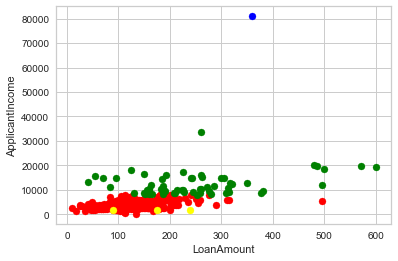

In [55]:
df0 = cls_df[cls_df['cluster_4']==0]
df1 = cls_df[cls_df['cluster_4']==1]
df2 = cls_df[cls_df['cluster_4']==2]
df3 = cls_df[cls_df['cluster_4']==3]


plt.scatter(df0["LoanAmount"], df0['ApplicantIncome'], color = 'red')#, c = cluster_labels, cmap='plasma')
plt.scatter(df1["LoanAmount"], df1['ApplicantIncome'], color = 'blue')
plt.scatter(df2["LoanAmount"], df2['ApplicantIncome'], color = 'green')
plt.scatter(df3["LoanAmount"], df3['ApplicantIncome'], color = 'yellow')


plt.xlabel("LoanAmount")
plt.ylabel("ApplicantIncome")
plt.legend()
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.9361388685275698
For n_clusters = 3 The average silhouette_score is : 0.627161881139582
For n_clusters = 4 The average silhouette_score is : 0.6408517460596348
For n_clusters = 5 The average silhouette_score is : 0.4886597480562134
For n_clusters = 6 The average silhouette_score is : 0.41328820715128606


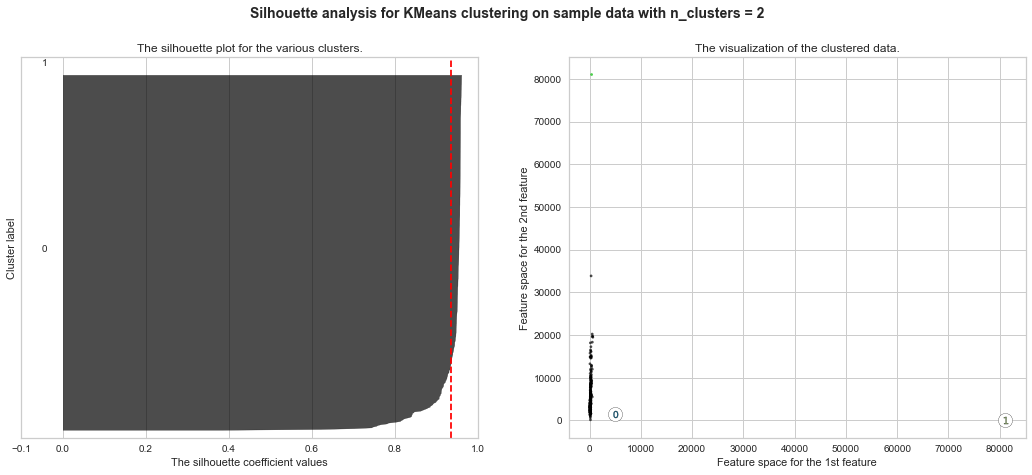

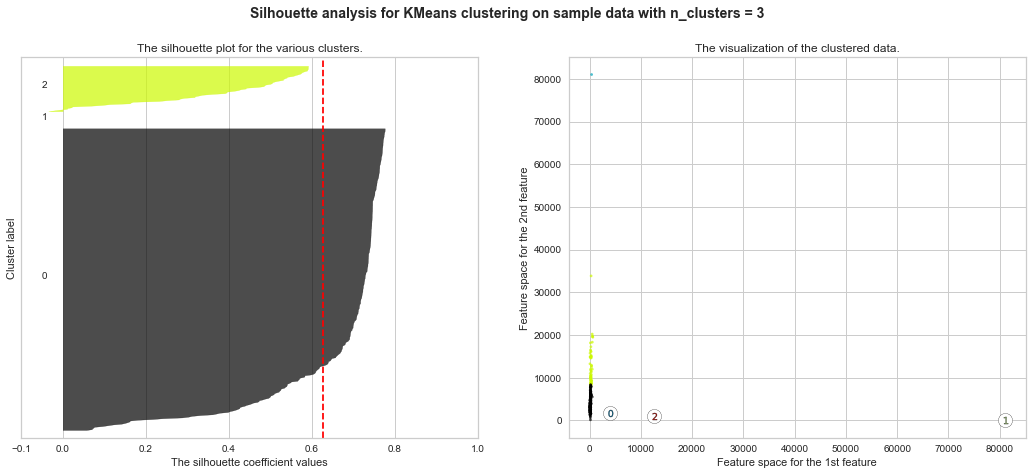

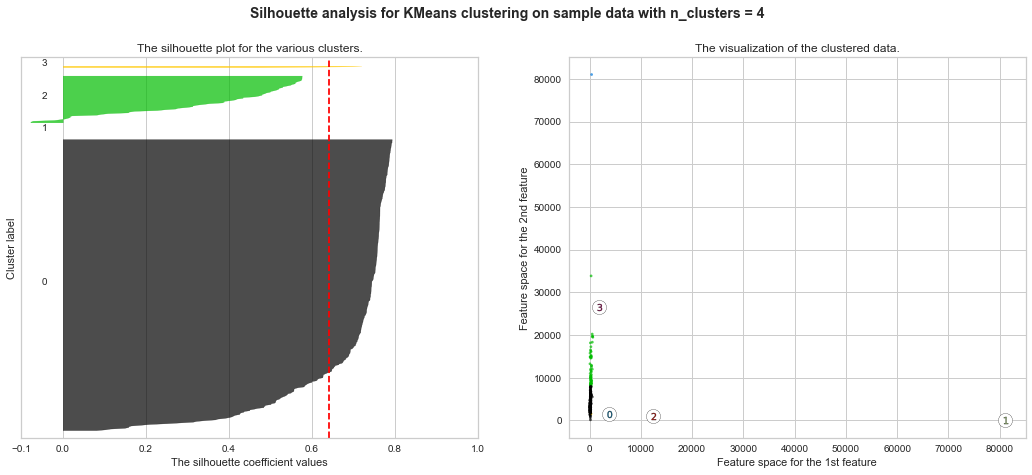

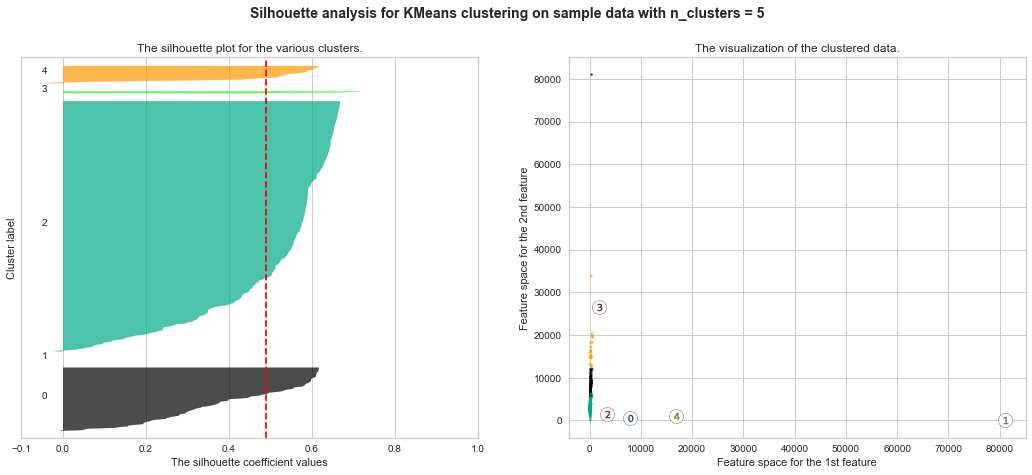

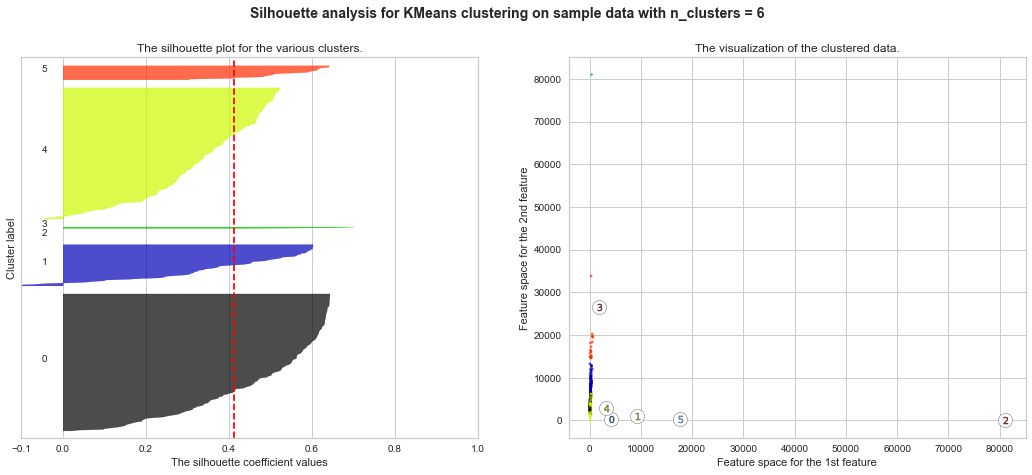

In [56]:
import matplotlib.cm as cm
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(train_n.drop('Loan_Status', axis=1)) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(train_n.drop('Loan_Status', axis=1))

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(train_n.drop('Loan_Status', axis=1), cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(train_n.drop('Loan_Status', axis=1), cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(train_n["LoanAmount"], train_n["ApplicantIncome"], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### from above graphs we can conlcude that k=2 is best choice here for clustering.

Read about selecting k using silhoute here
[silhoutte scoring](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

### Compare the pseudo-F statistics for the two cluster models. Which model is preferred? Explain your answer.

###### looks we have poor model need to improve the model

In [50]:
from scipy.stats import f_oneway
fitted_3 = clusterer.fit_transform(train_n)

fitted_3.shape
f_oneway(fitted_3[:,3:4], fitted_3[:,4:5])

F_onewayResult(statistic=array([], dtype=float64), pvalue=array([], dtype=float64))

###### from above, 5 clusters gives the best output

In [58]:
pca = PCA()
pca.fit(train_n)

PCA()

In [59]:
pca.explained_variance_ratio_

array([7.80382464e-01, 2.19384490e-01, 1.27608942e-04, 1.05343742e-04,
       3.07935594e-08, 1.82610759e-08, 1.50215706e-08, 9.41482032e-09,
       5.91062010e-09, 4.12910733e-09, 3.72407597e-09, 3.01597032e-09,
       2.54734759e-09, 6.69693422e-10])

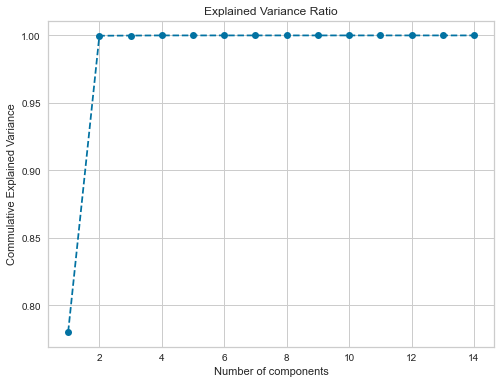

In [61]:
plt.figure(figsize=(8,6))
plt.plot(range(1,15), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title("Explained Variance Ratio")
plt.xlabel("Number of components")
plt.ylabel("Commulative Explained Variance")
plt.show()

In [62]:
pca = PCA(n_components=2)
pca.fit(train_n)

PCA(n_components=2)

In [63]:
trained = pca.transform(train_n)

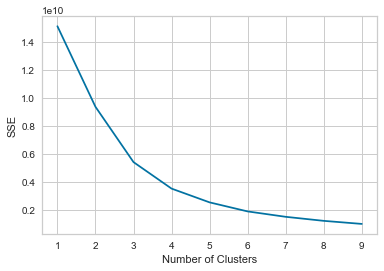

In [64]:
sse = {}
from sklearn.cluster import KMeans
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(trained)
    sse[k] = kmeans.inertia_
    
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### from above graph, here cluster 2 giving best result